In [4]:
# SIMPLE MODEL LOADING - Replace all the complex code above with this
import torch
import yaml
from pathlib import Path

from model import ModelConfig, Model
from train_utils import init_gpt_config, init_ssm_config


def load_pretrained_model(config_name="ntp_config", model_type="gpt", pretrained="next_token"):
    """
    Simplified function to load a pretrained model.
    """
    
    # Load config
    config_path = Path("./ntp_config.yaml")
    with config_path.open("r") as f:
        file_config = yaml.load(f, Loader=yaml.FullLoader)
    
    # Add model type
    file_config["model_type"] = model_type
    
    # Initialize model config based on type
    if model_type == "gpt":
        config_dict = init_gpt_config(file_config)
    else:
        config_dict = init_ssm_config(file_config)
    
    # Create ModelConfig object
    model_config = ModelConfig(**config_dict)
    
    # Create model
    model = Model(model_config)
    
    
    # Load pretrained weights if they exist
    if pretrained != "scratch":
        ckpt_path = Path("./ckpt.pt")
        ckpt_dir = Path("./ckpt")
        if not ckpt_path.exists() and not ckpt_dir.exists():
            raise FileNotFoundError(
                "Checkpoint not found at ./ckpt or ./ckpt.pt.\n\n"
                "Please download the checkpoint first:\n"
                "  1. Obtain the pretrained checkpoint (e.g. ckpt.pt) from https://drive.google.com/drive/folders/1qfdwQE2LpeZ1shGyrbX5y4xwze-DLbCF.\n"
                "  2. Place it in this directory as ./ckpt.pt\n"
                "Then re-run this notebook."
            )
        if ckpt_path.exists():
            pass  # use ckpt_path
        else:
            # look for .pt file inside ./ckpt
            pt_files = list(ckpt_dir.glob("*.pt"))
            if not pt_files:
                raise FileNotFoundError(
                    "Checkpoint directory ./ckpt exists but contains no .pt file.\n"
                    "Please download the checkpoint and place the .pt file in ./ckpt/."
                )
            ckpt_path = pt_files[0]
        ckpt_path = str(ckpt_path)
        print(f"Loading pretrained weights from {ckpt_path}")
        checkpoint = torch.load(ckpt_path, map_location="cpu")

        # Load state dict
        state_dict = checkpoint["model"]
        # Remove any unwanted prefixes
        unwanted_prefix = "_orig_mod."
        for k, v in list(state_dict.items()):
            if k.startswith(unwanted_prefix):
                state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)

        model.load_state_dict(state_dict, strict=False)
        print(f"Successfully loaded pretrained weights")
    else:
        print("Using randomly initialized weights (scratch)")
    
    
    print(f"Loaded {model_type} model")
    print(f"Model has {sum(p.numel() for p in model.parameters()) / 1e6:.2f}M parameters")
    
    return model, model_config

# Test it
model, config = load_pretrained_model("ntp_config", "gpt", "next_token")



INFO:model:No embedding tying performed
INFO:model:number of parameters: 108.53M


FileNotFoundError: Checkpoint not found at ./ckpt or ./ckpt.pt.

Please download the checkpoint first:
  1. Obtain the pretrained checkpoint (e.g. ckpt.pt) from https://drive.google.com/drive/folders/1qfdwQE2LpeZ1shGyrbX5y4xwze-DLbCF.
  2. Place it in this directory as ./ckpt.pt
Then re-run this notebook.

(array([  13.,  102.,  482., 1148., 1788., 1700., 1123.,  510.,  115.,
          22.]),
 array([-0.11858784, -0.09178841, -0.06498899, -0.03818956, -0.01139014,
         0.01540928,  0.04220871,  0.06900813,  0.09580755,  0.12260698,
         0.1494064 ], dtype=float32),
 <BarContainer object of 10 artists>)

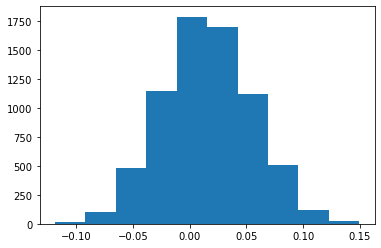

In [2]:
import matplotlib.pyplot as plt

plt.hist(model.embeddings[0].weight[:,0].detach().numpy())

In [4]:
import numpy as np

model.embeddings[0]

Embedding(7003, 768)

In [5]:
embd_x = model.embeddings[0].weight[:7000].detach().numpy()

from sklearn.decomposition import PCA
pca = PCA(n_components=10)
embd_x_pca = pca.fit_transform(embd_x)


/Users/ziming/opt/anaconda3/envs/chem/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


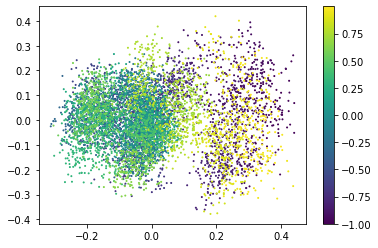

In [6]:
label = (np.arange(7000) - 3500) / 3500
plt.scatter(embd_x_pca[:,0], embd_x_pca[:,1], s=1, c=label)
plt.colorbar()
plt.show()


In [7]:
from sklearn.linear_model import LinearRegression
X = np.array(embd_x)
y = label

reg = LinearRegression().fit(X, y[:,None])
print(reg.score(X, y))
pred_x = reg.predict(X)

0.8592202839210397


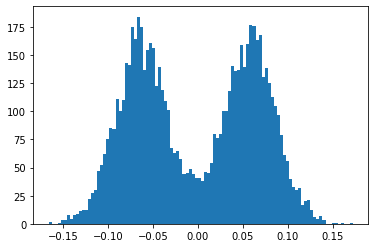

In [8]:
proj_vec = reg.coef_/np.linalg.norm(reg.coef_)
proj = X @ proj_vec.T
plt.hist(proj, bins=100);


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_31883/3732255079.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([-1, 1], [-1, 1], 'k--', color='red')


Text(0.3, 0.7, '$R^2$ = 0.8592')

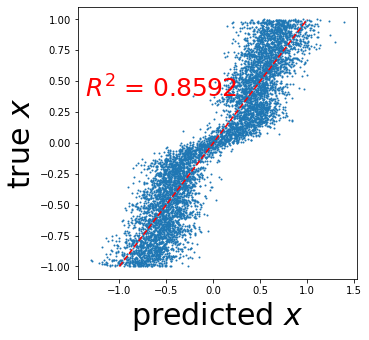

In [9]:
plt.figure(figsize=(5, 5))
plt.scatter(pred_x, label, s=1);
plt.xlabel('predicted '+r'$x$', fontsize=30)
plt.ylabel('true '+r'$x$', fontsize=30)
plt.plot([-1, 1], [-1, 1], 'k--', color='red')
plt.text(0.3, 0.7, r'$R^2$' + f' = 0.8592', ha='center', va='center', transform=plt.gca().transAxes, color='red', fontsize=25)
#plt.ylim(2000,5000)

#plt.savefig('./plots/x_scatter.png', dpi=300, bbox_inches='tight')

In [10]:
embd_y = model.embeddings[1].weight[:7000].detach().numpy()

from sklearn.linear_model import LinearRegression
X = np.array(embd_y)
y = label

reg = LinearRegression().fit(X, y[:,None])
print(reg.score(X, y))
pred_y = reg.predict(X)


0.8586854394222698


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_31883/93600183.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([-1, 1], [-1, 1], 'k--', color='red')


Text(0.3, 0.7, '$R^2$ = 0.8587')

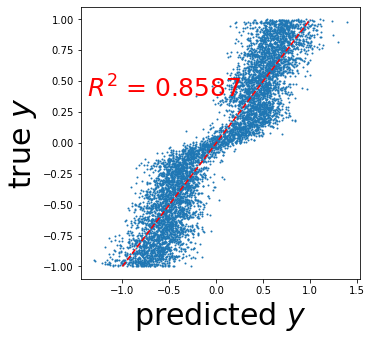

In [11]:
plt.figure(figsize=(5, 5))
plt.scatter(pred_x, label, s=1);
plt.xlabel('predicted '+r'$y$', fontsize=30)
plt.ylabel('true '+r'$y$', fontsize=30)
plt.plot([-1, 1], [-1, 1], 'k--', color='red')
plt.text(0.3, 0.7, r'$R^2$' + f' = 0.8587', ha='center', va='center', transform=plt.gca().transAxes, color='red', fontsize=25)
#plt.ylim(2000,5000)

#plt.savefig('./plots/y_scatter.png', dpi=300, bbox_inches='tight')

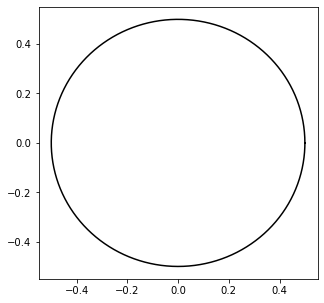

In [12]:
# draw a circle 
plt.figure(figsize=(5, 5))
radius = 0.5
n_points = 1000
theta = np.linspace(0, 2*np.pi, n_points)
X_circle = radius * np.cos(theta)
Y_circle = radius * np.sin(theta)
plt.plot(X_circle, Y_circle, color='black')


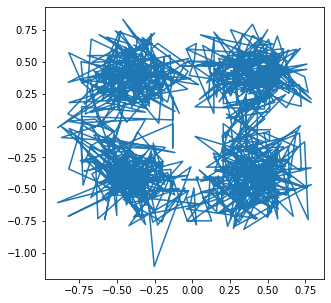

In [13]:
plt.figure(figsize=(5, 5))

pred_x_circle = pred_x[np.floor((X_circle - (-1)) / 2 * 7000).astype(int)]
pred_y_circle = pred_y[np.floor((Y_circle - (-1)) / 2 * 7000).astype(int)]
plt.plot(pred_x_circle, pred_y_circle)



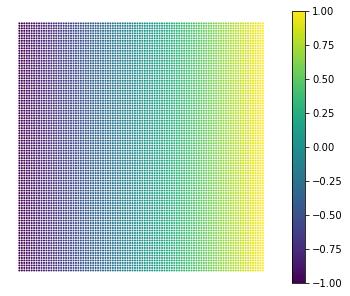

In [ ]:
plt.figure(figsize=(6, 5))
n_points = 100
X, Y = np.meshgrid(np.linspace(-1, 1, n_points), np.linspace(-1, 1, n_points))
plt.scatter(X, Y, s=1, c=X, alpha=1.0)
plt.colorbar()
plt.axis('off')
#plt.savefig('./plots/true_x_coord.png', dpi=300, bbox_inches='tight')
#plt.title('True x coordinates')
#plt.plot(X_circle, Y_circle, color='black')

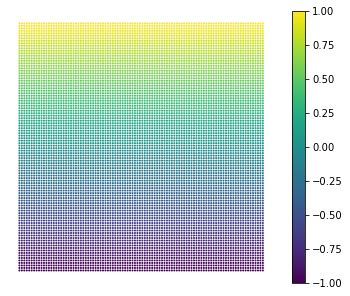

In [ ]:
plt.figure(figsize=(6, 5))
n_points = 100
X, Y = np.meshgrid(np.linspace(-1, 1, n_points), np.linspace(-1, 1, n_points))
plt.scatter(X, Y, s=1, c=Y, alpha=1.0)
plt.colorbar()
plt.axis('off')
#plt.savefig('./plots/true_y_coord.png', dpi=300, bbox_inches='tight')
#plt.title('True x coordinates')
#plt.plot(X_circle, Y_circle, color='black')

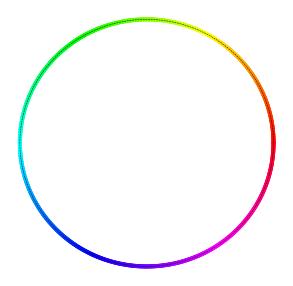

In [16]:
plt.figure(figsize=(5, 5))
plt.plot(X_circle, Y_circle, color='black', ls='--', lw=0.5)
plt.scatter(X_circle, Y_circle, c=np.arange(X_circle.shape[0]), cmap='hsv', s=10)
plt.axis('off');
#plt.savefig('./plots/true_circle.png', dpi=300, bbox_inches='tight')


(-0.9920075476169586,
 1.1088806927204131,
 -0.9545832276344299,
 1.008547604084015)

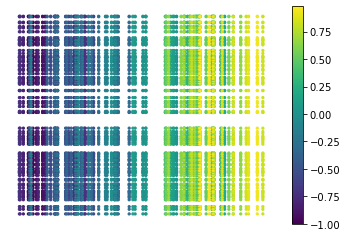

In [17]:
pred_x_i = pred_x[::7000 // n_points][:,0]
pred_y_i = pred_y[::7000 // n_points][:,0]
X_mess, Y_mess = np.meshgrid(pred_x_i, pred_y_i)
plt.scatter(X_mess, Y_mess, s=5, c=label[::7000 // n_points][None,:].repeat(n_points, axis=0), alpha=1.0)
plt.colorbar()
plt.axis('off')
#plt.savefig('./plots/pred_x_coord.png', dpi=300, bbox_inches='tight')
#plt.title('learned x coordinates')

#plt.plot(pred_x_circle, pred_y_circle, color='black', alpha=1.0, lw=0.5)

(-0.9920075476169586,
 1.1088806927204131,
 -0.9545832276344299,
 1.008547604084015)

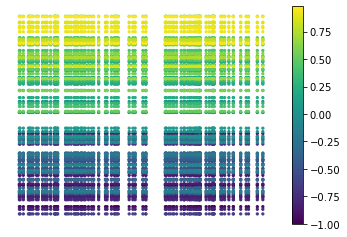

In [18]:
pred_x_i = pred_x[::7000 // n_points][:,0]
pred_y_i = pred_y[::7000 // n_points][:,0]
X_mess, Y_mess = np.meshgrid(pred_x_i, pred_y_i)
plt.scatter(X_mess, Y_mess, s=5, c=label[::7000 // n_points][None,:].repeat(n_points, axis=1), alpha=1.0)
plt.colorbar()
plt.axis('off')
#plt.savefig('./plots/pred_y_coord.png', dpi=300, bbox_inches='tight')

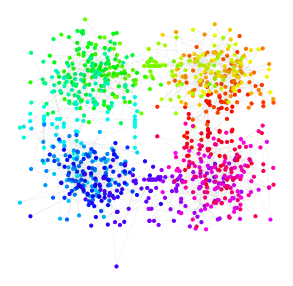

In [19]:
plt.figure(figsize=(5, 5))
plt.axis('off');
plt.plot(pred_x_circle, pred_y_circle, color='black', ls='--', lw=0.5, alpha=0.1)
plt.scatter(pred_x_circle, pred_y_circle, c=np.arange(pred_x_circle.shape[0]), cmap='hsv', s=10)
#plt.savefig('./plots/pred_circle.png', dpi=300, bbox_inches='tight')
